## Study Cluster Synchronization in the integration of the FHN model.

A personal notebook for the study of the synchronization of clusters in the FitzHugh-Nagumo model. This is meant for quick and dirty exploration of ideas, so it will not be too readable. Sorry!

### First, a test

Based on what is shown in the paper (https://doi.org/10.48550/arXiv.2303.08668), first we test with a complete graph.

In [1]:
include("src/msf.jl")
zero_msf = msf_zero()
println("zero_msf = ", zero_msf)
println("msf = ", master_stability_function(zero_msf, 0))

zero_msf = 0.2036388465071553
msf = 5.772580900970296e-18
5.772580900970296e-18


In [54]:
include("src/network_matrices_creation.jl")
include("src/cluster_synch.jl")
include("src/network_simulation.jl")

N = 10
eps = 0.05
a = 0.5
b = bmatrix(pi/2-0.1, eps)
G = test_matrix_for_cluster_synch();
eigenvalues, eigenvectors, clusters, s_matrices = s_matrix_method(G)
eigenvalues = unique(round.(eigenvalues, digits=8))[2:end]
critical_couplings = zero_msf./eigenvalues #unique(zero_msf./eigenvalues)[2:end]#
println("Critical Couplings: ", critical_couplings)
println("Eigenvalues: ", eigenvalues)
σ = critical_couplings[2]*0.9#*01.035


Critical Couplings: [0.02036388465071553, 0.011978755676891488, 0.009697087928912157]
Eigenvalues: [10.0, 17.0, 21.0]


0.01078088010920234

In [55]:
include("src/network_simulation.jl")
using Random
x_0 = zeros(2*N) + 0.001.*randn(2*N)
# x_0[2 .* (1:N) .- 1] = rand(N) .* 2 .* a .- a
# x_0[2 .* (1:N)] = rand(N) .* 2 .* (-a + a^3 / 3) .- (-a + a^3 / 3)
prob = ODEProblem((dx, x, params, t) -> coupled_fhn_eom!(dx, x, params[1], params[2], params[3], G, b, N), x_0, (0.0, 1000.0), [a, eps, σ])
sol = solve(prob; dtmax=0.01, maxiters=1e8);

In [59]:
using CairoMakie
CairoMakie.activate!(type = "svg")
# using GLMakie
include("src/cluster_synch.jl")
include("src/network_sol_analysis.jl")

fig = st_plot(sol, 150, 200 ; skip_every=10)
save("phase_time_cluster.svg", fig)

Plotting


CairoMakie.Screen{SVG}


In [4]:
# using CairoMakie
# CairoMakie.activate!(type = "svg")
using GLMakie
include("src/cluster_synch.jl")
include("src/network_sol_analysis.jl")

colors = ["#020202","#878F92", "#B20100", "#6C6C6C",  "#BE312B", "#F8F8F8", "#FFFFFF"]
# f = Figure(size= (900, 600), backgroundcolor = (:transparent), fontsize = 25)
f = Figure(size= (900, 600))
uni_clusters = unique(clusters)
for (i, cluster) in enumerate(uni_clusters)
    if isempty(cluster)
        continue
    else
        if i .< length(uni_clusters) && !isempty(uni_clusters[i+1])
            cluster = setdiff(cluster[1], uni_clusters[i+1][1])
        else
            cluster = cluster[1]
        end
        println("Cluster $i: $cluster")

        ax = Axis(f[i, 1], backgroundcolor = :transparent)
        ax.xlabel = "Time"
        ax.ylabel = "Synch Error"
        t_values, synch_error = local_synch_error(sol, cluster)
        lines!(ax, t_values, synch_error; label="Neurons $cluster", linewidth=1, color = colors[i])
        axislegend()
    end
end

display(f)

Cluster 1: [1, 2, 3]
Cluster 2: [4, 5, 6]
Cluster 3: [7, 8, 9, 10]


GLMakie.Screen(...)

In [6]:
using CairoMakie
using Trapz
using ProgressMeter
using Base.Threads

include("src/cluster_synch.jl")
include("src/network_sol_analysis.jl")

N_d = 100
N_realizations = 30
d_sweep = range(0.005, 0.025, length=N_d)
t_measurement = 500.0
t_transient = 1000.0
cluster_synchs = zeros(N_realizations, N_d, 3)
global_synchs = zeros(N_realizations, N_d)

uni_clusters = unique(clusters)
@showprogress for k in 1:N_d
    σ = d_sweep[k]
    for realization in 1:N_realizations
        x_0 = zeros(2*N) + 0.0001 .* randn(2*N)
        prob = ODEProblem((dx, x, params, t) -> coupled_fhn_eom!(dx, x, params[1], params[2], params[3], G, b, N), x_0, (0.0, t_transient + t_measurement), [a, eps, σ])
        # alg = Tsit5()
        sol = solve(prob; dtmax=0.5)
        t_val, global_synch = synch_error_time_series(sol)
        global_synchs[realization, k] = trapz(t_val[findfirst(t_val .> t_transient):end], global_synch[findfirst(t_val .> t_transient):end])/(t_measurement)
        for (i, cluster) in enumerate(uni_clusters)
            if isempty(cluster)
                continue
            else
                if i .< length(uni_clusters) && !isempty(uni_clusters[i+1])
                    cluster = setdiff(cluster[1], uni_clusters[i+1][1])
                else
                    cluster = cluster[1]
                end
                t_values, synch_error = local_synch_error(sol, cluster)
                # cluster_synch_averages[k, i] += trapz(t_values[findfirst(t_values .> t_transient):end], synch_error[findfirst(t_values .> t_transient):end])/(t_measurement * N_realizations)
                cluster_synchs[realization, k, i] = trapz(t_values[findfirst(t_values .> t_transient):end], synch_error[findfirst(t_values .> t_transient):end])/(t_measurement)
            end
        end
    end
end


Progress: 100%|█████████████████████████████████████████| Time: 0:08:25


In [7]:
global_synch_averages = mean(global_synchs, dims=1)[1, :]
cluster_synch_averages = mean(cluster_synchs, dims=1)[1, :, :]
cluster_synch_std = std(cluster_synchs, dims=1)[1, :, :]./sqrt(N_realizations)
colors = ["#020202","#878F92", "#B20100", "#6C6C6C",  "#BE312B", "#F8F8F8", "#FFFFFF"]
f = Figure(size= (800, 600), backgroundcolor = (:transparent), fontsize = 25)

ax = Axis(f[1, 1], backgroundcolor = :transparent)
ax.xlabel = "σ"
ax.ylabel = "Average Synch Error"
for i in 1:3
    cluster = uni_clusters[i]
    if i .< length(uni_clusters) && !isempty(uni_clusters[i+1])
        cluster = setdiff(cluster[1], uni_clusters[i+1][1])
    else
        cluster = cluster[1]
    end
    lines!(ax, d_sweep, cluster_synch_averages[:, i]; label="Cluster $cluster", color=colors[i])
    fill_between!(ax, d_sweep, cluster_synch_averages[:, i] - cluster_synch_std[:, i],
            cluster_synch_averages[:, i] + cluster_synch_std[:, i], color=(colors[i], 0.25))
end
lines!(ax, d_sweep, global_synch_averages; label="Global", linestyle=:dash, color=:black)
vlines!(ax, critical_couplings; label="Critical Couplings", linewidth=1, color = :red, linestyle=:dash)
axislegend()
save("clusters_vs_coupling.svg", f)

CairoMakie.Screen{SVG}


In [8]:
using CairoMakie
using Trapz
using ProgressMeter
using Base.Threads

include("src/cluster_synch.jl")
include("src/network_sol_analysis.jl")

N_d = 100
N_realizations = 50
d_sweep = range(0.005, 0.025, length=N_d)
t_measurement = 300.0
t_transient = 0.0
cluster_synchs_short = zeros(N_realizations, N_d, 3)
global_synchs_short = zeros(N_realizations, N_d)

uni_clusters = unique(clusters)
@showprogress for k in 1:N_d
    σ = d_sweep[k]
    for realization in 1:N_realizations
        x_0 = zeros(2*N) + 0.0001 .* randn(2*N)
        prob = ODEProblem((dx, x, params, t) -> coupled_fhn_eom!(dx, x, params[1], params[2], params[3], G, b, N), x_0, (0.0, t_transient + t_measurement), [a, eps, σ])
        # alg = Tsit5()
        sol = solve(prob; dtmax=0.5)
        t_val, global_synch = synch_error_time_series(sol)
        global_synchs_short[realization, k] = trapz(t_val[findfirst(t_val .> t_transient):end], global_synch[findfirst(t_val .> t_transient):end])/(t_measurement)
        for (i, cluster) in enumerate(uni_clusters)
            if isempty(cluster)
                continue
            else
                if i .< length(uni_clusters) && !isempty(uni_clusters[i+1])
                    cluster = setdiff(cluster[1], uni_clusters[i+1][1])
                else
                    cluster = cluster[1]
                end
                t_values, synch_error = local_synch_error(sol, cluster)
                # cluster_synch_averages[k, i] += trapz(t_values[findfirst(t_values .> t_transient):end], synch_error[findfirst(t_values .> t_transient):end])/(t_measurement * N_realizations)
                cluster_synchs_short[realization, k, i] = trapz(t_values[findfirst(t_values .> t_transient):end], synch_error[findfirst(t_values .> t_transient):end])/(t_measurement)
            end
        end
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:02:30


In [26]:
global_synch_averages = mean(global_synchs_short, dims=1)[1, :]
cluster_synch_averages = mean(cluster_synchs_short, dims=1)[1, :, :]
cluster_synch_std = std(cluster_synchs, dims=1)[1, :, :]./sqrt(N_realizations)
colors = ["#020202","#878F92", "#B20100", "#6C6C6C",  "#BE312B", "#F8F8F8", "#FFFFFF"]
f = Figure(size= (800, 600), backgroundcolor = (:transparent), fontsize=25)

ax = Axis(f[1, 1], backgroundcolor = :transparent)
ax.xlabel = "σ"
ax.ylabel = "Average Synch Error"
for i in 1:3
    cluster = uni_clusters[i]
    if i .< length(uni_clusters) && !isempty(uni_clusters[i+1])
        cluster = setdiff(cluster[1], uni_clusters[i+1][1])
    else
        cluster = cluster[1]
    end
    lines!(ax, d_sweep, cluster_synch_averages[:, i]; label="Cluster $cluster", color=colors[i])
    fill_between!(ax, d_sweep, cluster_synch_averages[:, i] - cluster_synch_std[:, i],
            cluster_synch_averages[:, i] + cluster_synch_std[:, i], color=(colors[i], 0.25))
end
lines!(ax, d_sweep, global_synch_averages; label="Global", linestyle=:dash, color=:black)
vlines!(ax, critical_couplings; label="Critical Couplings", linewidth=1, color = :red, linestyle=:dash)
axislegend()
save("clusters_vs_coupling_short.svg", f)

CairoMakie.Screen{SVG}


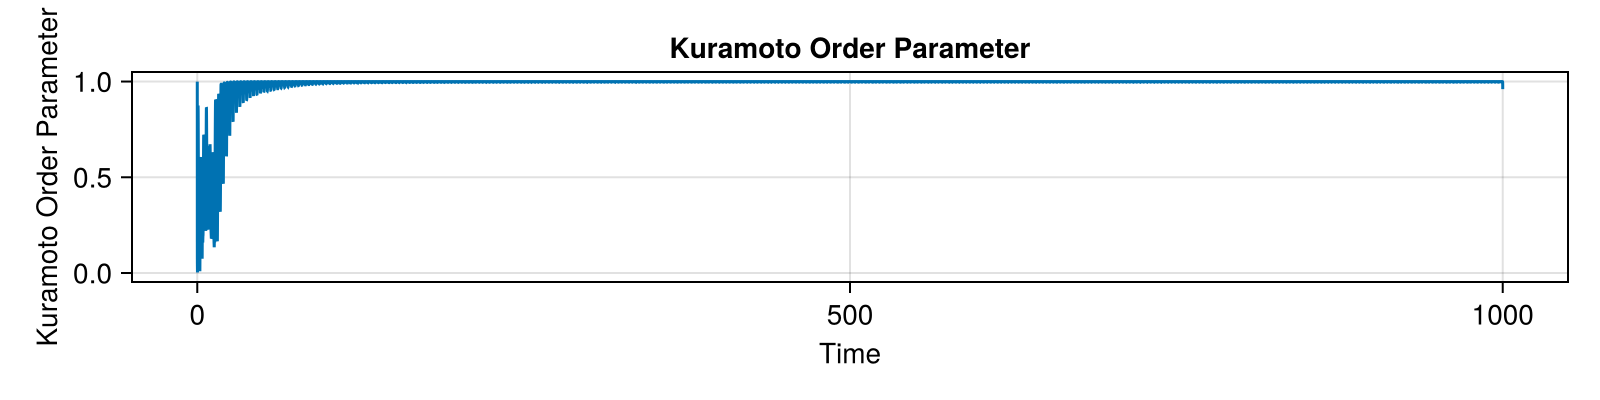

In [27]:
include("src/network_sol_analysis.jl")
using GLMakie
using LaTeXStrings

f = Figure(size = (800, 200))
ax = Axis(f[1, 1])
ax.title = "Kuramoto Order Parameter"
ax.xlabel = "Time"
ax.ylabel = "Kuramoto Order Parameter"
t_val, kuramoto_val = kuramoto_time_series(sol, N)
lines!(ax, t_val, kuramoto_val)
f

### Now for a watts-strogatz matrix

In [11]:
include("src/network_matrices_creation.jl")
include("src/cluster_synch.jl")
include("src/network_simulation.jl")

N = 90
eps = 0.05
a = 0.5
b = bmatrix(pi/2-0.1, eps)
G = wattsstrogatzmatrix(N, 3, 0.3);
eigenvalues, eigenvectors, clusters, s_matrices = s_matrix_method(G)
eigenvalues = unique(round.(eigenvalues, digits=8))[2:end]
critical_couplings = zero_msf./eigenvalues #unique(zero_msf./eigenvalues)[2:end]#
println("Critical Couplings: ", critical_couplings)
println("Eigenvalues: ", eigenvalues)
println("clusters: ", clusters)
println("len_clusters: ", length(clusters))
σ = 0.07

Critical Couplings: [0.23291670718825966, 0.219068665352694, 0.16990144801436388, 0.14336456541029177, 0.13022529161073693, 0.11506651440881481, 0.11125835452843508, 0.10812209593159973, 0.0976348876510438, 0.0922208624033414, 0.07943817190991945, 0.07717074298950771, 0.07268297739185584, 0.07158261118012522, 0.06578746469849016, 0.06290840075558327, 0.06052104285906904, 0.06029578242504168, 0.05639550062581257, 0.05423517370822493, 0.05211711615310405, 0.05000901967708295, 0.049403570777850236, 0.0473610851158561, 0.04627265179900082, 0.044677269599756556, 0.04359444403328287, 0.043267679436640595, 0.041669376451379275, 0.041063585165608985, 0.04033193195854326, 0.039323557087221836, 0.0384541570377673, 0.038194599926912425, 0.03764689144167584, 0.036703595463259096, 0.03648568057786352, 0.03573423932563895, 0.0352740732648549, 0.03496976477283023, 0.034593763999270534, 0.033971886441022024, 0.0335646263852138, 0.033146307307043966, 0.03260236646830293, 0.03210901244082044, 0.03159238

0.07

In [ ]:
include("src/network_simulation.jl")
using Random
σ = critical_couplings[5]*1.01
println("σ = ", σ)
x_0 = zeros(2*N)
x_0[2 .* (1:N) .- 1] = rand(N) .* 2 .* a .- a
x_0[2 .* (1:N)] = rand(N) .* 2 .* (-a + a^3 / 3) .- (-a + a^3 / 3)
prob = ODEProblem((dx, x, params, t) -> coupled_fhn_eom!(dx, x, params[1], params[2], params[3], G, b), x_0, (0.0, 1000.0), [a, eps, σ])
sol = solve(prob; dtmax=0.9);

In [ ]:
include("src/network_sol_analysis.jl")
st_plot(sol, 150, 300;skip_every=1)

# Figure creation

In [4]:
# using CairoMakie
using GLMakie
using Serialization
using Statistics

ws_forward = deserialize("ws_sweep_data/forward_array")
ws_backward = deserialize("ws_sweep_data/backward_array")
ws_forward_d_sweep = deserialize("ws_sweep_data/forward_d_sweep")[5:end-5]
ws_backward_d_sweep = deserialize("ws_sweep_data/backward_d_sweep")[5:end-5]
ws_forward_avg = mean(ws_forward, dims=1)[1, 5:end-5]
ws_backward_avg = mean(ws_backward, dims=1)[1, 5:end-5]
ws_forward_std = std(ws_forward, dims=1)[1, 5:end-5]./sqrt(length(ws_forward[:, 1]))
ws_backward_std = std(ws_backward, dims=1)[1, 5:end-5]./sqrt(length(ws_forward[:, 1]))

colors = ["#878F92", "#B20100"]
# f = Figure(size = (700, 500), backgroundcolor = (:transparent), fontsize=25)
f = Figure(size = (700, 500))
ax = Axis(f[1, 1], backgroundcolor = :transparent)
ax.xlabel = "σ"
ax.ylabel = "Kuramoto Order Parameter"
lines!(ax, ws_forward_d_sweep, ws_forward_avg; label="Decreasing coupling strength", color=colors[1])
lines!(ax, ws_backward_d_sweep, ws_backward_avg; label="Increasing coupling strength", color=colors[2])
fill_between!(ax, ws_forward_d_sweep, ws_forward_avg - ws_forward_std, ws_forward_avg + ws_forward_std, color=(colors[1], 0.25))
fill_between!(ax, ws_backward_d_sweep, ws_backward_avg - ws_backward_std, ws_backward_avg + ws_backward_std, color=(colors[2], 0.25))
axislegend(position=:rb)
# save("ws_adiabatic.svg", f)
# include("src/network_matrices_creation.jl")
# include("src/cluster_synch.jl")
# include("src/msf.jl")
# zero_msf = msf_zero()
# critical_couplings = zeros(89)
# for i in 1:100
#     G = wattsstrogatzmatrix(90, 3, 1)
#     eigenvalues, eigenvectors, clusters, s_matrices = s_matrix_method(G)
#     non_zero_eigvals = eigenvalues[2:end]
#     critical_couplings .+= zero_msf./non_zero_eigvals
# end
# critical_couplings ./= 100

# vlines!(ax, critical_couplings, label="Critical Couplings", linewidth=1, color = :red, linestyle=:dash)
display(f)




GLMakie.Screen(...)

In [8]:
using CSV, DataFrames

forward_df = DataFrame("Forward d sweep" => ws_forward_d_sweep, "Corresponding averaged value" => ws_forward_avg, "Corresponding standard deviation" => ws_forward_std)
CSV.write("ws_forward_d_sweep.csv", forward_df)

backward_df = DataFrame("Backward d sweep" => ws_backward_d_sweep, "Corresponding averaged value" => ws_backward_avg, "Corresponding standard deviation" => ws_backward_std)
CSV.write("ws_backward_d_sweep.csv", backward_df)


"ws_backward_d_sweep.csv"

In [ ]:
using CairoMakie
using Serialization
using Statistics

cluster_forward = deserialize("cluster_sweep_data/cluster_forward")
cluster_backward = deserialize("cluster_sweep_data/cluster_backward")
forward_d_sweep = deserialize("cluster_sweep_data/forward_d_sweep")
backward_d_sweep = deserialize("cluster_sweep_data/backward_d_sweep")
global_forward = deserialize("cluster_sweep_data/global_forward")
global_backward = deserialize("cluster_sweep_data/global_backward")

global_forward_avg = mean(global_forward, dims=1)[1, :]
global_backward_avg = mean(global_backward, dims=1)[1, :]
cluster_forward_avg = mean(cluster_forward, dims=1)[1, :, :]
cluster_backward_avg = mean(cluster_backward, dims=1)[1, :, :]

global_forward_std = std(global_forward, dims=1)[1, :]./sqrt(length(global_forward[:, 1]))
global_backward_std = std(global_backward, dims=1)[1, :]./sqrt(length(global_backward[:, 1]))
cluster_forward_std = std(cluster_forward, dims=1)[1, :, :]./sqrt(length(cluster_forward[:, 1, 1]))
cluster_backward_std = std(cluster_backward, dims=1)[1, :, :]./sqrt(length(cluster_backward[:, 1, 1]))

critical_couplings = [0.020373021436669875, 0.011984130256864633, 0.009701438779366607]
unique_clusters =  [[1, 2, 3],
[4, 5, 6],
[7, 8, 9, 10]]
colors = ["#020202", "#878F92", "#B20100", "#6C6C6C",  "#BE312B", "#F8F8F8", "#FFFFFF"]

f = Figure(size = (1800, 600), backgroundcolor = (:transparent), fontsize=25)


for i in 1:length(unique_clusters)
    cluster = unique_clusters[i]
    if i ==1
        global new_ax = Axis(f[1, i], backgroundcolor = :transparent)
    else
        global new_ax = Axis(f[1, i], backgroundcolor = :transparent)
    end
    new_ax.title = "Cluster $cluster"
    new_ax.xlabel = "σ"
    new_ax.ylabel = "Average Normalized Synch Error"
    lines!(new_ax, forward_d_sweep[5:end-5], cluster_forward_avg[5:end-5, i]./maximum(cluster_forward_avg[5:end-5, i]), color=colors[3], label="Cluster Decreasing") # 6000 timesteps for thermalization
    lines!(new_ax, backward_d_sweep[5:end-5], cluster_backward_avg[5:end-5, i]./maximum(cluster_backward_avg[5:end-5, i]), color=colors[2], label="Cluster Increasing")
    lines!(new_ax, forward_d_sweep[5:end-5], global_forward_avg[5:end-5]./maximum(global_forward_avg[5:end-5]), color=colors[1],linestyle = :dash, label="Entire Network Decreasing") # 5000 timesteps for thermalization
    lines!(new_ax, backward_d_sweep[5:end-5], global_backward_avg[5:end-5]./maximum(global_backward_avg[5:end-5]), color=colors[4],linestyle=:dash, label="Entire Network Increasing")
    fill_between!(new_ax, forward_d_sweep[5:end-5], cluster_forward_avg[5:end-5, i]./maximum(cluster_forward_avg[5:end-5, i]) - cluster_forward_std[5:end-5, i]./maximum(cluster_forward_avg[5:end-5, i]),
            cluster_forward_avg[5:end-5, i]./maximum(cluster_forward_avg[5:end-5, i]) + cluster_forward_std[5:end-5, i]./maximum(cluster_forward_avg[5:end-5, i]), color=(colors[3], 0.25))
    fill_between!(new_ax, backward_d_sweep[5:end-5], cluster_backward_avg[5:end-5, i]./maximum(cluster_backward_avg[5:end-5, i]) - cluster_backward_std[5:end-5, i]./maximum(cluster_backward_avg[5:end-5, i]),
            cluster_backward_avg[5:end-5, i]./maximum(cluster_backward_avg[5:end-5, i]) + cluster_backward_std[5:end-5, i]./maximum(cluster_backward_avg[5:end-5, i]), color=(colors[2], 0.25))
    fill_between!(new_ax, forward_d_sweep[5:end-5], global_forward_avg[5:end-5]./maximum(global_forward_avg[5:end-5]) - global_forward_std[5:end-5]./maximum(global_forward_avg[5:end-5]),
            global_forward_avg[5:end-5]./maximum(global_forward_avg[5:end-5]) + global_forward_std[5:end-5]./maximum(global_forward_avg[5:end-5]), color=(colors[1], 0.25))
    fill_between!(new_ax, backward_d_sweep[5:end-5], global_backward_avg[5:end-5]./maximum(global_backward_avg[5:end-5]) - global_backward_std[5:end-5]./maximum(global_backward_avg[5:end-5]),
            global_backward_avg[5:end-5]./maximum(global_backward_avg[5:end-5]) + global_backward_std[5:end-5]./maximum(global_backward_avg[5:end-5]), color=(colors[4], 0.25))
    
    vlines!(new_ax, critical_couplings[1:3]; label="Critical Couplings", linestyle=:dash, color = :red)
    axislegend(new_ax, position=:rt)
end
save("clusters_adiabatic_sweep.svg", f)
f


# Test for epsilon = 1.0


In [ ]:
include("src/msf.jl")
eps = 0.05
phi = pi/2-0.1
zero_msf = msf_zero(eps=eps, phi=phi)
println("zero_msf = ", zero_msf)
println("msf = ", master_stability_function(zero_msf, 0, eps=eps, phi=phi))

In [ ]:
include("src/network_matrices_creation.jl")
include("src/cluster_synch.jl")
include("src/network_simulation.jl")

N = 10
a = 0.5
b = bmatrix(phi, eps)
G = test_matrix_for_cluster_synch();
eigenvalues, eigenvectors, clusters, s_matrices = s_matrix_method(G)
eigenvalues = unique(round.(eigenvalues, digits=8))[2:end]
critical_couplings = zero_msf./eigenvalues #unique(zero_msf./eigenvalues)[2:end]#
println("Critical Couplings: ", critical_couplings)
println("Eigenvalues: ", eigenvalues)
σ = critical_couplings[3]*01.1


In [ ]:
include("src/network_simulation.jl")
using Random
x_0 = zeros(2*N) + 0.0001.*randn(2*N)
# x_0[2 .* (1:N) .- 1] = rand(N) .* 2 .* a .- a
# x_0[2 .* (1:N)] = rand(N) .* 2 .* (-a + a^3 / 3) .- (-a + a^3 / 3)
prob = ODEProblem((dx, x, params, t) -> coupled_fhn_eom!(dx, x, params[1], params[2], params[3], G, b, N), x_0, (0.0, 100000.0), [a, eps, σ])
sol = solve(prob; dtmax=0.9, maxiters=1e8);

In [ ]:
using GLMakie
CairoMakie.activate!(type = "svg")
include("src/cluster_synch.jl")
include("src/network_sol_analysis.jl")

colors = ["#020202","#878F92", "#B20100", "#6C6C6C",  "#BE312B", "#F8F8F8", "#FFFFFF"]
f = Figure(size= (900, 600), backgroundcolor = (:transparent), fontsize = 25)
uni_clusters = unique(clusters)
for (i, cluster) in enumerate(uni_clusters)
    if isempty(cluster)
        continue
    else
        if i .< length(uni_clusters) && !isempty(uni_clusters[i+1])
            cluster = setdiff(cluster[1], uni_clusters[i+1][1])
        else
            cluster = cluster[1]
        end
        println("Cluster $i: $cluster")

        ax = Axis(f[i, 1], backgroundcolor = :transparent)
        ax.xlabel = "Time"
        ax.ylabel = "Synch Error"
        t_values, synch_error = local_synch_error(sol, cluster)
        lines!(ax, t_values, synch_error; label="Neurons $cluster", linewidth=1, color = colors[i])
        axislegend()
    end
end
display(f)

In [ ]:
lines(sol.t[1:1000], sol[1, 1:1000])

# Creating phase space plots for a Watts-Strogatz network

### Simulating the network:

In [13]:
include("src/network_matrices_creation.jl")
include("src/network_simulation.jl")
include("src/network_sol_analysis.jl")
using GLMakie
using LaTeXStrings
using Random
using BenchmarkTools

N = 90
eps = 0.05
a = 0.5
b = bmatrix(pi/2-0.1, eps)
σ = 0.07
G = wattsstrogatzmatrix(N, 3, 1) .* 1.0

x_0 = zeros(2*N) + 0.1.*randn(2*N)
# x_0[2 .* (1:N) .- 1] = rand(N) .* 2 .* a .- a
# x_0[2 .* (1:N)] = rand(N) .* 2 .* (-a + a^3 / 3) .- (-a + a^3 / 3)
prob = ODEProblem((dx, x, params, t) -> coupled_fhn_eom!(dx, x, params[1], params[2], params[3], G, b, N), x_0, (0.0, 1000.0), [a, eps, σ])
sol = solve(prob, dtmax=0.01);


### FIgure creation:

In [14]:
f = Figure(size = (600, 600), fontsize=25)
ax = Axis3(f[1, 1])
x, y, z = sol[1, 10000:end], sol[2, 10000:end], sol[3, 10000:end]
lines!(ax,  x, y, z)
xs = LinRange(minimum(sol[1, :]), maximum(sol[1, :]), 10)
ys = LinRange(minimum(sol[2, :]), maximum(sol[2, :]), 10)
zs = [x for x in xs, y in ys]
surface!(ax, xs, ys, zs, alpha=0.4, colorscale=x -> 1)
ax.xlabel = L"$u_1$"
ax.ylabel = L"$v_1$"
ax.zlabel = L"$u_2$"

angles = LinRange(0, 2π, 100)
perspective = sin.(angles).^2
framerate = 30
record(f, "test_anim.gif", angles;
        framerate = framerate) do angle
    ax.perspectiveness = perspective[findfirst(angles .≈ angle)]
    ax.azimuth = angle
end


InterruptException: InterruptException:

In [ ]:
include("src/network_sol_analysis.jl")
u_avg = mean(sol[1:2:2*N, 10000:end], dims=1)[1, :]
v_avg = mean(sol[2:2:2*N, 10000:end], dims=1)[1, :]
synch_error= synch_error_time_series(sol)[2][10000:end]
# function distance_to_synch_manifold(vector)
#     synch_component = ones(N)./sqrt(N)
#     u = vector[1:2:2*N]
#     v = vector[2:2:2*N]
#     u_norm_of_component_in_manifold = dot(synch_component, u)^2
#     v_norm_of_component_in_manifold = dot(synch_component, v)^2
#     return sqrt(norm(u)^2 - u_norm_of_component_in_manifold + norm(v)^2 - v_norm_of_component_in_manifold)
# end

# d_transverse = zeros(length(u_avg))
# for i in length(u_avg)
#     d_transverse[i] = distance_to_synch_manifold(sol[:, 10000+i-1])
# end

f = Figure(size = (800, 800), fontsize=25)
ax = Axis3(f[1, 1])
zlims!(ax, 0, 2)
lines!(ax, u_avg, v_avg, synch_error)

ax.xlabel = L"$\langle u \rangle$"
ax.ylabel = L"$\langle v \rangle$"
ax.zlabel = L"\langle E_S \rangle"
f

In [ ]:
using GLMakie # All functionality is defined in Makie and every backend re-exports Makie

points = Observable(Point3f[]) # Signal that can be used to update plots efficiently
colors = Observable(Int[])

set_theme!(theme_black())

fig, ax, l = lines(points, color = colors, colormap = :inferno, transparency = true, axis = (; type = Axis3, viewmode = :fit, limits = (-2.2, 2.2, -1.1, 1.1, -2.2, 2.2)))

ax.xlabel = L"$u_1$"
ax.ylabel = L"$v_1$"
ax.zlabel = L"$u_2$"
              

x, y, z = sol[1, 10000:end], sol[2, 10000:end], sol[3, 10000:end]
len_x = length(x)
println(len_x)
final_frame = 10000
trail = 250
skip_every = 5
record(fig, "phase_space.mp4", 1:skip_every:final_frame; framerate=60) do frame
    for i in 1:skip_every
        push!(points[], Point3f(x[frame+i], y[frame+i], z[frame+i]))
        push!(colors[], frame)
    end
    ax.azimuth[] = 2pi * frame/final_frame # set the view angle of the axis
    if frame > trail*skip_every
        for i in 1:skip_every
            popfirst!(points[])
            popfirst!(colors[])
        end
    end
    notify(points); notify(colors) # tell points and colors that their value has been updated
    l.colorrange = (frame-trail*skip_every, frame) # update plot attribute directly
end

# Testing the method described by Fu et. al. (2012) (Synchronous patterns in complex systems)

### First, we test with a simulation of a fixed WS network

In [18]:
G = wattsstrogatzmatrix(N, 3, 1) .* 1.0;


In [ ]:
include("src/network_matrices_creation.jl")
include("src/network_simulation.jl")
include("src/network_sol_analysis.jl")
using GLMakie
using LaTeXStrings
using Random
using BenchmarkTools

N = 10
eps = 0.05
a = 0.5
b = bmatrix(pi/2-0.1, eps)
σ = 0.1718
G = test_matrix_for_cluster_synch()

x_0 = zeros(2*N) + 0.1.*randn(2*N)
# x_0[2 .* (1:N) .- 1] = rand(N) .* 2 .* a .- a
# x_0[2 .* (1:N)] = rand(N) .* 2 .* (-a + a^3 / 3) .- (-a + a^3 / 3)
prob = ODEProblem((dx, x, params, t) -> coupled_fhn_eom!(dx, x, params[1], params[2], params[3], G, b, N), x_0, (0.0, 1000.0), [a, eps, σ])
sol = solve(prob, dtmax=0.01);

### Plot for the individual synchronization errors

In [25]:
include("src/network_sol_analysis.jl")
using GLMakie
using LaTeXStrings

t, err = individual_synch_error_time_series(sol)

f = Figure()
ax = Axis(f[1, 1])
ax.xlabel = "Time"
ax.ylabel = "Neuron"
heatmap!(ax, t[1:10:end], 1:90, err[1:10:end, :])
f